In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Interpolations
using PyPlot
using MAT

include("../mast/readers.jl")
using .ShipPosmv

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# read the VectorNav file
# line:
# Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
#
# 21 science data fields delimited by commas

function read_nd_vecnav( file )
    # allocate arrays
    nlmax = countlines(file)
    dt = Vector{DateTime}(undef, nlmax)
    intdata = Matrix{Int64}(undef, nlmax, 2)
    data = Matrix{Float32}(undef, nlmax, 19)

    # read it >>BLACK PUMAS<<
    nl = 0
    df = dateformat"uuuHH:MM:SSyyyy"
    open( file ) do f
        for line in readlines(f)
            # Tue Mar 28 13:17:11 2023 +0000, 9431257000, -163.267792, -1.067281, -1.441135, -0.011044, 0.011087, -0.989255, 0.145364, 0.000000, 0.000000, 0.000000, 0.234963, -0.005458, 0.101274, 0.432598, -0.534912, -9.797964, 0.000000, 0.000000, 0.000000
            nl += 1
            spl = split(line, r"[\ ,]+")
            try
                dt[nl] = ( 
                    DateTime(spl[2], dateformat"u") + Day(parse(Int8, spl[3])) 
                  + Year(parse(Int16, spl[5])-1) 
                  +(DateTime(spl[4], dateformat"HH:MM:SS") - DateTime(1,1,1)) )
                intdata[nl,:] .= parse.(Int64, spl[6:7])  #  2
                data[nl,:] .= parse.(Float32, spl[8:end]) # 19
            catch
                @show line
            end
        end
    end
    return dt[1:nl], intdata[1:nl,:], data[1:nl,:]
end

read_nd_vecnav (generic function with 1 method)

In [3]:
file = "./data/lidar/table/VectorNavTableData.txt"

dt, intdata, data = read_nd_vecnav( file ) 
# very big slow read: 12 minutes -> 1.5 min once compiled
# (dt, intdata, data) = ans

([DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11"), DateTime("2023-03-29T13:17:11")  …  DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31"), DateTime("2023-04-13T17:52:31")], [0 9431257000; 0 9475007000; … ; 0 1399716032996841472; 0 1399716033009341440], Float32[-163.26779 -1.067281 … 0.0 0.0; -163.09041 -1.044217 … 0.0 0.0; … ; -112.596375 0.066772 … -0.898887 -0.145727; -112.59639 0.065914 … -0.899769 -0.146437])

In [20]:
# check stuff that's zero
an0(x) = any(x .!= 0)
an0(intdata[:,1])

# , data[:,16:19]])


false

In [28]:
Vnav = Dict{String, Any}()
Vnav["dt"] = dt     # Only Dicts with string keys may be saved as MATLAB structs
Vnav["inttime"] = intdata[:,2]
Vnav["data"] = data

using MAT
# Open a MAT file for writing
matopen("VectorNavTable.mat", "w") do matfile
    # Write the variables to the MAT file
    write(matfile, "dt", Dates.value.(dt.-dt[1]))
    write(matfile, "inttime", intdata[:,2])
    write(matfile, "data", data)
    # Close the MAT file
    close(matfile)
end

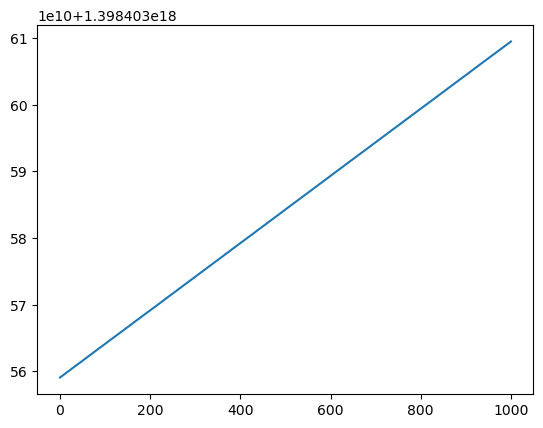

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x333034cd0>

In [97]:
plot(intdata[1000:2000,2])

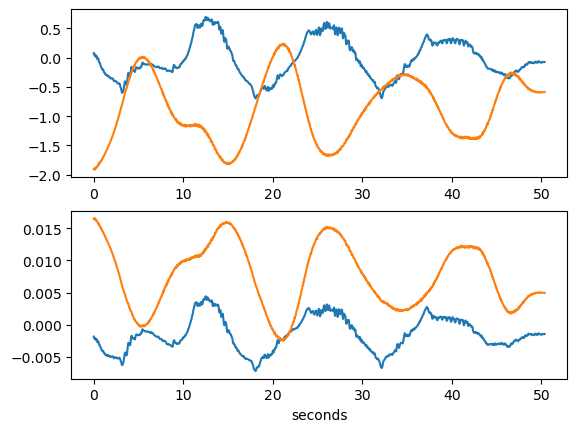

PyObject Text(0.5, 24.0, 'seconds')

In [99]:
clf()
subplot(2,1,1)
plot((intdata[1000:2000,2].-intdata[1000,2])/1e9, data[1000:2000,2:3])
subplot(2,1,2)
plot((intdata[1000:2000,2].-intdata[1000,2])/1e9, data[1000:2000,4:5])
xlabel("seconds")
# intdata[:,2] is nanoseconds

In [64]:
data[1:400,2:3] ./ data[1:400,4:5] # almost, not quite proportional


400×2 Matrix{Float32}:
 96.639   -129.984
 95.7207  -129.446
 95.688   -129.058
 94.6972  -128.501
 94.482   -128.064
 93.2551  -127.401
 93.5147  -127.4
 91.3759  -126.172
 91.7227  -126.193
 90.8163  -125.682
 89.5446  -125.061
 88.7875  -124.593
 87.9697  -124.391
  ⋮       
 34.6541  -117.215
 32.7031  -117.121
 33.0644  -117.134
 36.0     -117.275
 37.5824  -117.359
 35.6465  -117.259
 37.6336  -117.359
 38.8622  -117.434
 40.6736  -117.541
 39.665   -117.474
 39.1784  -117.448
 34.9201  -117.215

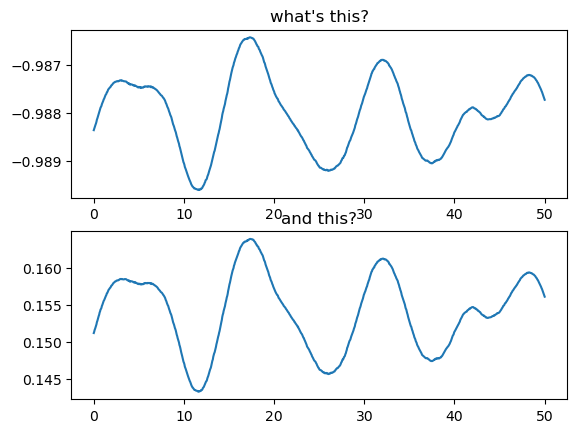

PyObject Text(0.5, 1.0, 'and this?')

In [100]:
subplot(2,1,1)
plot((0:1000)*0.05, data[1000:2000,6])
title("what's this?")
subplot(2,1,2)
plot((0:1000)*0.05, data[1000:2000,7])
title("and this?")

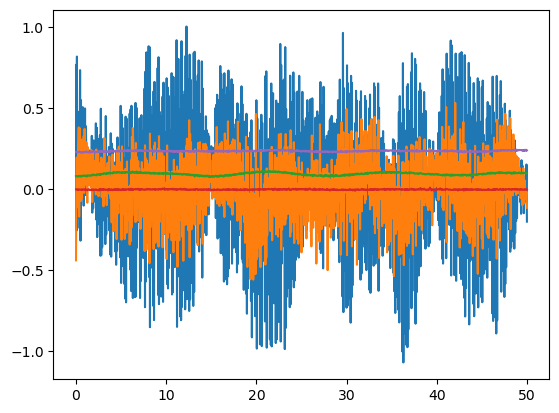

5-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3332ef130>
 PyObject <matplotlib.lines.Line2D object at 0x3332afe50>
 PyObject <matplotlib.lines.Line2D object at 0x3332afc70>
 PyObject <matplotlib.lines.Line2D object at 0x3332afb80>
 PyObject <matplotlib.lines.Line2D object at 0x3332ad600>

In [102]:
plot((0:1000).*0.05,data[1000:2000,[15, 14, 13, 12, 11]])

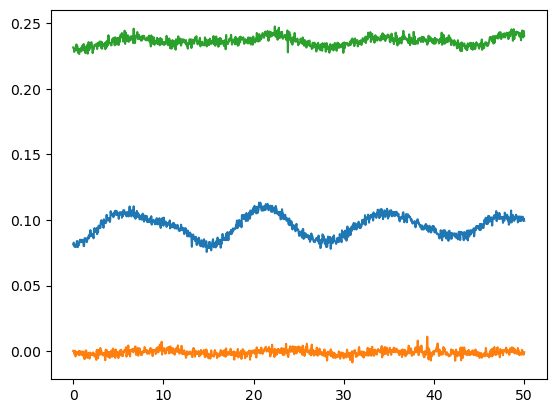

3-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x333384940>
 PyObject <matplotlib.lines.Line2D object at 0x333384970>
 PyObject <matplotlib.lines.Line2D object at 0x333384a60>

In [103]:
plot((0:1000).*0.05,data[1000:2000,[13, 12, 11]])